In [1]:
import os
import numpy as np
import pandas as pd # original 1.2.3
import geopandas as gpd
from shapely.geometry import Point
import pickle
import urllib.request
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}df_ucdp_prio.pkl', 'rb') as file:
    prio_ucdp = pickle.load(file)

In [3]:
coords_long = prio_ucdp[['gid', 'xcoord', 'ycoord']].copy() # conveniet for plotting
coords = coords_long.groupby('gid').mean()
coords.reset_index(inplace = True)

In [4]:
# bdist3 capdist gcp_mer gcp_ppp excluded nlights_mean nlights_calib_mean 
# petroleum_y pop_gpw_sum pop_gpw_sd prec_gpcp urban_ih agri_ih pasture_ih
# barren_ih irrig_sum imr_mean cmr_mean mountain_mean  ttime_mean

location = '/home/simon/Documents/Bodies/data/PRIO'
path_yearly = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-09-08.csv' #https://grid.prio.org/#/download 
path_static = location + '/PRIO-GRID Static Variables - 2022-09-08.csv' #https://grid.prio.org/#/download 

yearly_df = pd.read_csv(path_yearly)
yearly_df = yearly_df.merge(coords, on='gid', how='left') # for plotting. faster to scatter then geopandas plot

static_df = pd.read_csv(path_static)
static_df = static_df.merge(coords, on='gid', how='left') # for plotting. faster to scatter then geopandas plot



In [5]:
df = yearly_df.copy()

In [6]:
df.sort_values(['gid', 'year'], inplace=True)

In [7]:
def expl_interpl_extrapl(data, feature_list):
    
    n_months = 12
    n_gid = data['gid'].unique().shape[0] # number of groups
    n_years = data['year'].unique().shape[0] # number of years

    # list of lists with temporal sub unites. eg. months
    months = [list(np.arange(1, n_months+1))] * data.shape[0] # list of lists with temporal sub unites. eg. months

    # append the colum
    data['month'] = months 

    # explode the df in reference to the new col and drop the ond index
    data = data.explode('month').reset_index(drop=True) 

    # we'll only keep the original values in the first tempoeal sub unit. Interpolate rest.
    data.loc[data['month'] != 1, feature_list] = np.nan 

    


    # number of year x number of months. And then number of groups
    data['month_id'] = list(range(n_years * n_months)) * n_gid 

    # to be used below
    obs_features_list = []

    for f in feature_list:
        observed_col_name = f'{f}_observed'

        # an identifier for the non-interpolated values
        data[observed_col_name] = data.loc[:,f].notna() 
        obs_features_list.append(observed_col_name)

    # interpolate and extrapolate
    data = data.groupby('gid').apply(lambda x: x.interpolate(method='linear', axis = 0, limit_direction = 'both', fill_value='extrapolate'))


    # clip at group observed min and max for each feature.
    for f, o in list(zip(feature_list, obs_features_list)):
        data[f] = data.groupby('gid').apply(lambda x: np.clip(x[f], x[x[o] == True][f].min(), x[x[o] == True][f].max())).reset_index(drop=True)

    return(data)

In [8]:
feature_list = list(df.columns[2:-2])
new_df = expl_interpl_extrapl(df, feature_list)

In [10]:
new_df.to_pickle('test_interpolate.pkl')

In [14]:
new_df.columns

Index(['gid', 'year', 'agri_ih', 'barren_ih', 'bdist3', 'capdist', 'excluded',
       'gcp_mer', 'gcp_ppp', 'irrig_sum', 'nlights_calib_mean', 'nlights_mean',
       'pasture_ih', 'petroleum_y', 'pop_gpw_sd', 'pop_gpw_sum', 'prec_gpcp',
       'urban_ih', 'xcoord', 'ycoord', 'month', 'month_id', 'agri_ih_observed',
       'barren_ih_observed', 'bdist3_observed', 'capdist_observed',
       'excluded_observed', 'gcp_mer_observed', 'gcp_ppp_observed',
       'irrig_sum_observed', 'nlights_calib_mean_observed',
       'nlights_mean_observed', 'pasture_ih_observed', 'petroleum_y_observed',
       'pop_gpw_sd_observed', 'pop_gpw_sum_observed', 'prec_gpcp_observed',
       'urban_ih_observed'],
      dtype='object')

In [18]:
new_df.sample(10)

,gid,year,agri_ih,barren_ih,bdist3,capdist,excluded,gcp_mer,gcp_ppp,irrig_sum,...,gcp_ppp_observed,irrig_sum_observed,nlights_calib_mean_observed,nlights_mean_observed,pasture_ih_observed,petroleum_y_observed,pop_gpw_sd_observed,pop_gpw_sum_observed,prec_gpcp_observed,urban_ih_observed
266255,74090,1998,NaN,NaN,30.13908,553.0468,0.0,1.450183,1.725696,NaN,...,False,False,False,False,False,False,False,False,False,False
18952712,230139,2011,NaN,NaN,27.19414,1662.7630,0.0,0.000104,0.000439,0.000000,...,False,False,False,False,False,False,False,False,False,False
8565875,173324,2007,0.00,60.030000,13.79609,446.7770,1.0,0.002201,0.007705,140.197900,...,False,False,False,False,False,False,False,False,False,False
15162115,212910,2002,0.00,6.154167,363.33290,2253.8180,1.0,0.006703,0.028312,0.000000,...,False,False,False,False,False,False,False,False,False,False
7643128,166699,1994,0.00,58.774333,37.84349,1355.4860,1.0,0.000503,0.001767,0.501100,...,False,False,False,False,False,False,False,False,False,False
3185005,117977,1998,NaN,NaN,16.18611,2376.5440,NaN,0.003869,0.011422,21.828767,...,False,False,False,False,False,False,False,False,False,False
8985568,176243,2012,0.18,23.480000,535.72280,1604.3100,1.0,0.012996,0.031786,32.235300,...,False,False,False,False,False,False,False,False,False,False
12266124,197736,2002,28.76,0.000000,55.18283,1176.4350,0.0,0.008542,0.036080,1094.730600,...,False,False,True,True,False,True,False,False,True,False
7828218,168139,2000,0.00,93.240500,50.08964,1255.2800,1.0,0.000611,0.002117,0.000000,...,False,False,False,False,False,False,False,False,False,False
9746263,181893,1989,31.52,0.000000,45.05403,471.1042,1.0,0.130251,0.697025,4940.530000,...,False,False,False,False,False,False,False,False,False,False


169

In [ ]:

for i in new_df.columns:
    rand_month_id = np.random.choice(new_df['month_id'])
    x = new_df.loc[new_df['month_id'] == rand_month_id, 'xcoord'] 
    y = new_df.loc[new_df['month_id'] == rand_month_id, 'ycoord'] 
    t = new_df.loc[new_df['month_id'] == rand_month_id, i] 
    plt.scatter()

In [ ]:
    print(col)
    plt.figure(figsize=[28,12])
    plt.scatter(sub_yearly_df['xcoord'], sub_yearly_df['ycoord'], c = sub_yearly_df[col], cmap = 'rainbow', marker = 's', s = 2)
    plt.show()

# OLD

In [21]:
# SEEMS TO WORK!!!
df_interpolate = df.groupby('gid').apply(lambda x: x.interpolate(method='linear', axis = 0, limit_direction = 'both'))

In [22]:
df_interpolate

,gid,year,agri_ih,barren_ih,bdist3,capdist,excluded,gcp_mer,gcp_ppp,irrig_sum,nlights_calib_mean,nlights_mean,pasture_ih,petroleum_y,pop_gpw_sd,pop_gpw_sum,prec_gpcp,urban_ih,xcoord,ycoord
0,49182,1989,NaN,NaN,27.00977,2480.495,NaN,0.000578,0.001080,0.0,0.000000,0.0,NaN,NaN,0.150595,5.731053,1009.4620,NaN,-69.25,-55.75
10,49182,1990,NaN,NaN,27.00977,2480.495,NaN,0.000578,0.001080,0.0,0.000000,0.0,NaN,NaN,0.150595,5.731053,984.8367,NaN,-69.25,-55.75
4,49182,1991,NaN,NaN,27.00977,2480.495,NaN,0.000651,0.001215,0.0,0.000000,0.0,NaN,NaN,0.155597,5.921409,1114.7160,NaN,-69.25,-55.75
15,49182,1992,NaN,NaN,27.00977,2480.495,NaN,0.000723,0.001351,0.0,0.000000,0.0,NaN,NaN,0.160599,6.111765,1060.0260,NaN,-69.25,-55.75
12,49182,1993,NaN,NaN,27.00977,2480.495,NaN,0.000796,0.001486,0.0,0.015551,0.0,NaN,NaN,0.165601,6.302122,1107.6370,NaN,-69.25,-55.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685259,249344,2010,NaN,NaN,24.71215,4223.597,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,169.8687,NaN,-68.25,83.25
1685249,249344,2011,NaN,NaN,24.71215,4223.597,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,142.3017,NaN,-68.25,83.25
1685263,249344,2012,NaN,NaN,24.71215,4223.597,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,145.4478,NaN,-68.25,83.25
1685265,249344,2013,NaN,NaN,24.71215,4223.597,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.000000,0.000000,131.1454,NaN,-68.25,83.25


- have a dumme of original values
- plot samples to see.
- se om du kan gører det til mdr. pandas explode...

In [25]:
test_gid = 180640
df_interpolate[df_interpolate['gid'] == test_gid]['agri_ih']

799682    19.000
799686    19.000
799696    18.721
799694    18.442
799700    18.163
799698    17.884
799707    17.605
799706    17.326
799685    17.047
799693    16.768
799699    16.489
799684    16.210
799702    15.931
799704    15.652
799688    15.373
799683    15.094
799692    14.815
799697    14.536
799687    14.257
799691    13.978
799690    13.699
799695    13.420
799705    13.420
799701    13.420
799703    13.420
799689    13.420
Name: agri_ih, dtype: float64

In [26]:
test_gid = 180640
df[df['gid'] == test_gid]['agri_ih']

799682      NaN
799686    19.00
799696      NaN
799694      NaN
799700      NaN
799698      NaN
799707      NaN
799706      NaN
799685      NaN
799693      NaN
799699      NaN
799684    16.21
799702      NaN
799704      NaN
799688      NaN
799683      NaN
799692      NaN
799697      NaN
799687      NaN
799691      NaN
799690      NaN
799695    13.42
799705      NaN
799701      NaN
799703      NaN
799689      NaN
Name: agri_ih, dtype: float64

In [ ]:
# prof of concept

In [119]:
ex_test = pd.DataFrame({'value': [60,70,90,140,300,120], 'year' : [1990, 1991, 1992,1990, 1991, 1992], 'group' : [1,1,1,2,2,2]}) # some df ith vlaues, temporal unites and groups
ex_test

,value,year,group
0,NaN,1990,1
1,70.0,1991,1
2,90.0,1992,1
3,140.0,1990,2
4,300.0,1991,2
5,120.0,1992,2


In [120]:
q = [[1,2]] * ex_test.shape[0] # list of lists with temporal sub unites. eg. months
ex_test['quarter'] = q # append the colum
ex_test = ex_test.explode('quarter').reset_index(drop=True) # explode the df in reference to the new col and drop the ond index
ex_test.loc[ex_test['quarter'] != 1, 'value'] = np.nan # we'll only keep the original values in the first tempoeal sub unit. Interpolate rest.
ex_test


,value,year,group,quarter
0,NaN,1990,1,1
1,NaN,1990,1,2
2,70.0,1991,1,1
3,NaN,1991,1,2
4,90.0,1992,1,1
5,NaN,1992,1,2
6,140.0,1990,2,1
7,NaN,1990,2,2
8,300.0,1991,2,1
9,NaN,1991,2,2


In [121]:
nt = ex_test['year'].unique().shape[0] * ex_test['quarter'].unique().shape[0] # number of time unites
gn = ex_test['group'].unique().shape[0] # number of groups

ex_test['t_id'] = list(range(nt)) * gn # uniq temporal idenitfier

In [122]:
ex_test

,value,year,group,quarter,t_id
0,NaN,1990,1,1,0
1,NaN,1990,1,2,1
2,70.0,1991,1,1,2
3,NaN,1991,1,2,3
4,90.0,1992,1,1,4
5,NaN,1992,1,2,5
6,140.0,1990,2,1,0
7,NaN,1990,2,2,1
8,300.0,1991,2,1,2
9,NaN,1991,2,2,3


In [123]:
#ex_test = ex_test.groupby('group').apply(lambda x: x.interpolate(method='polynomial', order = 2, axis = 0, limit_direction = 'both'))

#ex_test = ex_test.groupby('group').apply(lambda x: interpolate.interp1d(x, ex_test['t_id'].unique(), fill_value='extrapolate'))
#f = interpolate.interp1d(x, ex_test['t_id'].unique(), fill_value='extrapolate')

ex_test = ex_test.groupby('group').apply(lambda x: x.interpolate(method='linear', axis = 0, limit_direction = 'both', fill_value='extrapolate'))


ex_test

,value,year,group,quarter,t_id
0,70.0,1990,1,1,0
1,70.0,1990,1,2,1
2,70.0,1991,1,1,2
3,80.0,1991,1,2,3
4,90.0,1992,1,1,4
5,90.0,1992,1,2,5
6,140.0,1990,2,1,0
7,220.0,1990,2,2,1
8,300.0,1991,2,1,2
9,210.0,1991,2,2,3


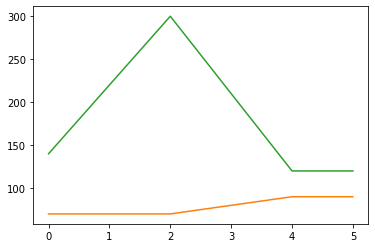

In [124]:
for i in range(3):
    plt.plot(ex_test.loc[ex_test['group'] == i, 't_id'], ex_test.loc[ex_test['group'] == i, 'value'])
plt.show()

In [25]:
df.groupby('gid').apply(lambda x: x.interpolate(method='linear', axis = 0, limit_direction = 'both'))

,value,year,t
0,1.000000,1990,1
0,1.333333,1990,2
0,1.666667,1990,3
1,2.000000,1991,1
1,2.333333,1991,2
1,2.666667,1991,3
2,3.000000,1992,1
2,3.000000,1992,2
2,3.000000,1992,3


In [13]:
df = yearly_df.copy()
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.index = df['year']
df.sort_index(inplace= True)
del df['year']

NameError: name 'yearly_df' is not defined

In [ ]:
df

,gid,agri_ih,barren_ih,bdist3,capdist,excluded,gcp_mer,gcp_ppp,irrig_sum,nlights_calib_mean,nlights_mean,pasture_ih,petroleum_y,pop_gpw_sd,pop_gpw_sum,prec_gpcp,urban_ih,xcoord,ycoord
year,,,,,,,,,,,,,,,,,,,
1989-01-01,49182,NaN,NaN,27.009770,2480.4950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1009.46200,NaN,-69.25,-55.75
1989-01-01,176888,NaN,NaN,244.817300,540.7513,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.41490,NaN,63.75,32.75
1989-01-01,176887,NaN,NaN,209.786600,584.2097,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.41490,NaN,63.25,32.75
1989-01-01,219985,NaN,NaN,8.205569,492.7421,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1547.32200,NaN,12.25,62.75
1989-01-01,176886,NaN,NaN,180.395100,628.0812,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.41490,NaN,62.75,32.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01,179873,NaN,NaN,268.118200,574.9055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,866.22880,NaN,116.25,34.75
2014-01-01,163086,NaN,NaN,288.369000,1498.2690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.68428,NaN,2.75,23.25
2014-01-01,210982,NaN,NaN,21.879500,6625.5470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,729.32780,NaN,-169.25,56.75


In [ ]:
# df_interpol = df.groupby('gid').resample('Y').mean()
#df_interpol = df.groupby('gid').apply(lambda x: x.interpolate(method='linear'))


In [ ]:
df_interpol = df.groupby('gid').apply(lambda x: x.interpolate(method='linear', axis = 0))
# df_interpol = df.groupby('gid').apply(lambda x: x.interpolate(method='linear', axis = 0)).bfill().ffill()


KeyboardInterrupt: 

In [ ]:
df_interpol.shape == df.shape

True

In [ ]:
dum = pd.DataFrame({'time': [1,2,3,4,5,1,2,3,4,5],'group': [1,1,1,1,1,2,2,2,2,2], 'value1': [np.nan,10,np.nan,20,np.nan,1,np.nan,np.nan,4,np.nan],'value2': [np.nan,100,np.nan,200,np.nan,10,np.nan,np.nan,40,np.nan]})
dum

,time,group,value1,value2
0,1,1,NaN,NaN
1,2,1,10.0,100.0
2,3,1,NaN,NaN
3,4,1,20.0,200.0
4,5,1,NaN,NaN
5,1,2,1.0,10.0
6,2,2,NaN,NaN
7,3,2,NaN,NaN
8,4,2,4.0,40.0
9,5,2,NaN,NaN


In [ ]:
dum.groupby('group').apply(lambda x: x.interpolate(method='linear', axis = 0, limit_direction = 'both')) 

,time,group,value1,value2
0,1,1,10.0,100.0
1,2,1,10.0,100.0
2,3,1,15.0,150.0
3,4,1,20.0,200.0
4,5,1,20.0,200.0
5,1,2,1.0,10.0
6,2,2,2.0,20.0
7,3,2,3.0,30.0
8,4,2,4.0,40.0
9,5,2,4.0,40.0


In [ ]:
agri_ih = df.groupby('gid')['agri_ih'].apply(lambda x: x.interpolate(method='linear')) #.bfill()

KeyboardInterrupt: 

In [ ]:
test_gid = 180640
df_interpol[df_interpol['gid'] == test_gid]['agri_ih'].sort_index()

gid     year      
180640  1989-12-31      NaN
        1990-12-31    19.00
        1991-12-31      NaN
        1992-12-31      NaN
        1993-12-31      NaN
        1994-12-31      NaN
        1995-12-31      NaN
        1996-12-31      NaN
        1997-12-31      NaN
        1998-12-31      NaN
        1999-12-31      NaN
        2000-12-31    16.21
        2001-12-31      NaN
        2002-12-31      NaN
        2003-12-31      NaN
        2004-12-31      NaN
        2005-12-31      NaN
        2006-12-31      NaN
        2007-12-31      NaN
        2008-12-31      NaN
        2009-12-31      NaN
        2010-12-31    13.42
        2011-12-31      NaN
        2012-12-31      NaN
        2013-12-31      NaN
        2014-12-31      NaN
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
df[df['gid'] == test_gid]['agri_ih'].sort_index()

year
1989-01-01      NaN
1990-01-01    19.00
1991-01-01      NaN
1992-01-01      NaN
1993-01-01      NaN
1994-01-01      NaN
1995-01-01      NaN
1996-01-01      NaN
1997-01-01      NaN
1998-01-01      NaN
1999-01-01      NaN
2000-01-01    16.21
2001-01-01      NaN
2002-01-01      NaN
2003-01-01      NaN
2004-01-01      NaN
2005-01-01      NaN
2006-01-01      NaN
2007-01-01      NaN
2008-01-01      NaN
2009-01-01      NaN
2010-01-01    13.42
2011-01-01      NaN
2012-01-01      NaN
2013-01-01      NaN
2014-01-01      NaN
Name: agri_ih, dtype: float64

In [ ]:
#df_interpol_done = df_interpol.interpolate(method='linear', axis=0).copy()
#df_interpol_done = df.interpolate(method='linear', axis=0).copy()
df_interpol_done = df_interpol.ffill().bfill().copy()


In [ ]:
test_gid = 180640
df_interpol_done[df_interpol_done['gid'] == test_gid]['agri_ih'].sort_index()

gid     year      
180640  1989-12-31     0.00
        1990-12-31    19.00
        1991-12-31    19.00
        1992-12-31    19.00
        1993-12-31    19.00
        1994-12-31    19.00
        1995-12-31    19.00
        1996-12-31    19.00
        1997-12-31    19.00
        1998-12-31    19.00
        1999-12-31    19.00
        2000-12-31    16.21
        2001-12-31    16.21
        2002-12-31    16.21
        2003-12-31    16.21
        2004-12-31    16.21
        2005-12-31    16.21
        2006-12-31    16.21
        2007-12-31    16.21
        2008-12-31    16.21
        2009-12-31    16.21
        2010-12-31    13.42
        2011-12-31    13.42
        2012-12-31    13.42
        2013-12-31    13.42
        2014-12-31    13.42
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
df_interpol_done[df_interpol_done['gid'] == test_gid]['agri_ih'].sort_index()

year
1989-01-01          NaN
1990-01-01    19.000000
1991-01-01     0.000000
1992-01-01     0.000000
1993-01-01     0.000000
1994-01-01     0.000000
1995-01-01     0.000000
1996-01-01     0.000000
1997-01-01     0.000000
1998-01-01     0.000000
1999-01-01     0.000000
2000-01-01    16.210000
2001-01-01     1.049898
2002-01-01     1.697408
2003-01-01     2.422931
2004-01-01     3.205825
2005-01-01     4.626010
2006-01-01     4.944847
2007-01-01     6.328153
2008-01-01     6.776738
2009-01-01     7.674087
2010-01-01    13.420000
2011-01-01     0.010000
2012-01-01     0.010000
2013-01-01     0.010000
2014-01-01     0.010000
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
df_interpolate[df_interpolate['gid'] == test_gid]['agri_ih']


799682    19.000
799686    19.000
799696    18.721
799694    18.442
799700    18.163
799698    17.884
799707    17.605
799706    17.326
799685    17.047
799693    16.768
799699    16.489
799684    16.210
799702    15.931
799704    15.652
799688    15.373
799683    15.094
799692    14.815
799697    14.536
799687    14.257
799691    13.978
799690    13.699
799695    13.420
799705    13.420
799701    13.420
799703    13.420
799689    13.420
Name: agri_ih, dtype: float64

In [ ]:
df_interpol = df.groupby('gid').bfill()
df_interpol['gid'] = df['gid']

In [ ]:
df_interpol_done = df_interpol.interpolate(method='linear', axis=0, limit_area = 'outside').copy()
df_interpol_done.head(4)

gid  agri_ih  barren_ih    bdist3   capdist  excluded  \
gid   year                                                                    
49182 1989-12-31  49182.0      NaN        NaN  27.00977  2480.495       NaN   
      1990-12-31  49182.0      NaN        NaN  27.00977  2480.495       NaN   
      1991-12-31  49182.0      NaN        NaN  27.00977  2480.495       NaN   
      1992-12-31  49182.0      NaN        NaN  27.00977  2480.495       NaN   

                   gcp_mer  gcp_ppp  irrig_sum  nlights_calib_mean  \
gid   year                                                           
49182 1989-12-31       NaN      NaN        NaN                 NaN   
      1990-12-31  0.000578  0.00108        0.0                 NaN   
      1991-12-31       NaN      NaN        NaN                 NaN   
      1992-12-31       NaN      NaN        NaN                 0.0   

                  nlights_mean  pasture_ih  petroleum_y  pop_gpw_sd  \
gid   year                                                            
49182 1989-12-31           NaN         NaN          NaN         NaN   
      1990-12-31           NaN         NaN          NaN    0.150595   
      1991-12-31           NaN         NaN          NaN         NaN   
      1992-12-31           0.0         NaN          NaN         NaN   

                  pop_gpw_sum  prec_gpcp  urban_ih  xcoord  ycoord  
gid   year                                                          
49182 1989-12-31          NaN  1009.4620       NaN  -69.25  -55.75  
      1990-12-31     5.731053   984.8367       NaN  -69.25  -55.75  
      1991-12-31          NaN  1114.7160       NaN  -69.25  -55.75  
      1992-12-31          NaN  1060.0260       NaN  -69.25  -55.75

In [ ]:
test_gid = 180640
df_interpol[df_interpol['gid'] == test_gid]['agri_ih'].sort_index()

gid     year      
180640  1989-12-31      NaN
        1990-12-31    19.00
        1991-12-31      NaN
        1992-12-31      NaN
        1993-12-31      NaN
        1994-12-31      NaN
        1995-12-31      NaN
        1996-12-31      NaN
        1997-12-31      NaN
        1998-12-31      NaN
        1999-12-31      NaN
        2000-12-31    16.21
        2001-12-31      NaN
        2002-12-31      NaN
        2003-12-31      NaN
        2004-12-31      NaN
        2005-12-31      NaN
        2006-12-31      NaN
        2007-12-31      NaN
        2008-12-31      NaN
        2009-12-31      NaN
        2010-12-31    13.42
        2011-12-31      NaN
        2012-12-31      NaN
        2013-12-31      NaN
        2014-12-31      NaN
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
df_interpol_done[df_interpol_done['gid'] == test_gid]['agri_ih']

gid     year      
180640  1989-12-31      NaN
        1990-12-31    19.00
        1991-12-31      NaN
        1992-12-31      NaN
        1993-12-31      NaN
        1994-12-31      NaN
        1995-12-31      NaN
        1996-12-31      NaN
        1997-12-31      NaN
        1998-12-31      NaN
        1999-12-31      NaN
        2000-12-31    16.21
        2001-12-31      NaN
        2002-12-31      NaN
        2003-12-31      NaN
        2004-12-31      NaN
        2005-12-31      NaN
        2006-12-31      NaN
        2007-12-31      NaN
        2008-12-31      NaN
        2009-12-31      NaN
        2010-12-31    13.42
        2011-12-31      NaN
        2012-12-31      NaN
        2013-12-31      NaN
        2014-12-31      NaN
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
df_interpol_done[df_interpol_done['gid'] == test_gid]['agri_ih']

gid     year      
180640  1989-12-31      NaN
        1990-12-31    19.00
        1991-12-31      NaN
        1992-12-31      NaN
        1993-12-31      NaN
        1994-12-31      NaN
        1995-12-31      NaN
        1996-12-31      NaN
        1997-12-31      NaN
        1998-12-31      NaN
        1999-12-31      NaN
        2000-12-31    16.21
        2001-12-31      NaN
        2002-12-31      NaN
        2003-12-31      NaN
        2004-12-31      NaN
        2005-12-31      NaN
        2006-12-31      NaN
        2007-12-31      NaN
        2008-12-31      NaN
        2009-12-31      NaN
        2010-12-31    13.42
        2011-12-31      NaN
        2012-12-31      NaN
        2013-12-31      NaN
        2014-12-31      NaN
Name: agri_ih, dtype: float64

In [ ]:
test_gid = 180640
test_df = yearly_df.copy()
test_df = test_df[test_df['gid'] == test_gid][['agri_ih', 'year']].sort_values('year').set_index('year')
#test_df.interpolate(method='linear', axis=0, inplace=True)
test_df

,agri_ih
year,
1989,NaN
1990,19.00
1991,NaN
1992,NaN
1993,NaN
1994,NaN
1995,NaN
1996,NaN
1997,NaN


In [ ]:
test_gid = 180640
test_df = yearly_df.copy()
test_df = test_df[test_df['gid'] == test_gid][['agri_ih', 'year']].sort_values('year').set_index('year')
test_df.interpolate(method='linear', axis=0, inplace=True)
test_df

,agri_ih
year,
1989,NaN
1990,19.000
1991,18.721
1992,18.442
1993,18.163
1994,17.884
1995,17.605
1996,17.326
1997,17.047


In [ ]:
yearly_df.head()

,gid,year,agri_ih,barren_ih,bdist3,capdist,excluded,gcp_mer,gcp_ppp,irrig_sum,nlights_calib_mean,nlights_mean,pasture_ih,petroleum_y,pop_gpw_sd,pop_gpw_sum,prec_gpcp,urban_ih,xcoord,ycoord
0,49182,1989,NaN,NaN,27.00977,2480.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1009.4620,NaN,-69.25,-55.75
1,49182,1997,NaN,NaN,27.00977,2480.495,NaN,NaN,NaN,NaN,0.014398,0.0,NaN,NaN,NaN,NaN,941.1174,NaN,-69.25,-55.75
2,49182,1999,NaN,NaN,27.00977,2480.495,NaN,NaN,NaN,NaN,0.029603,0.0,NaN,NaN,NaN,NaN,1025.7230,NaN,-69.25,-55.75
3,49182,2003,NaN,NaN,27.00977,2480.495,NaN,NaN,NaN,NaN,0.035479,0.0,NaN,NaN,NaN,NaN,992.3161,NaN,-69.25,-55.75
4,49182,1991,NaN,NaN,27.00977,2480.495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1114.7160,NaN,-69.25,-55.75


In [ ]:
test_gid = 180640
test_df = yearly_df[yearly_df['gid'] == test_gid][['agri_ih', 'year']].sort_values('year').set_index('year')
test_df.interpolate(method='linear', axis=0, inplace=True)
test_df

,agri_ih
year,
1989,NaN
1990,19.000
1991,18.721
1992,18.442
1993,18.163
1994,17.884
1995,17.605
1996,17.326
1997,17.047


gid


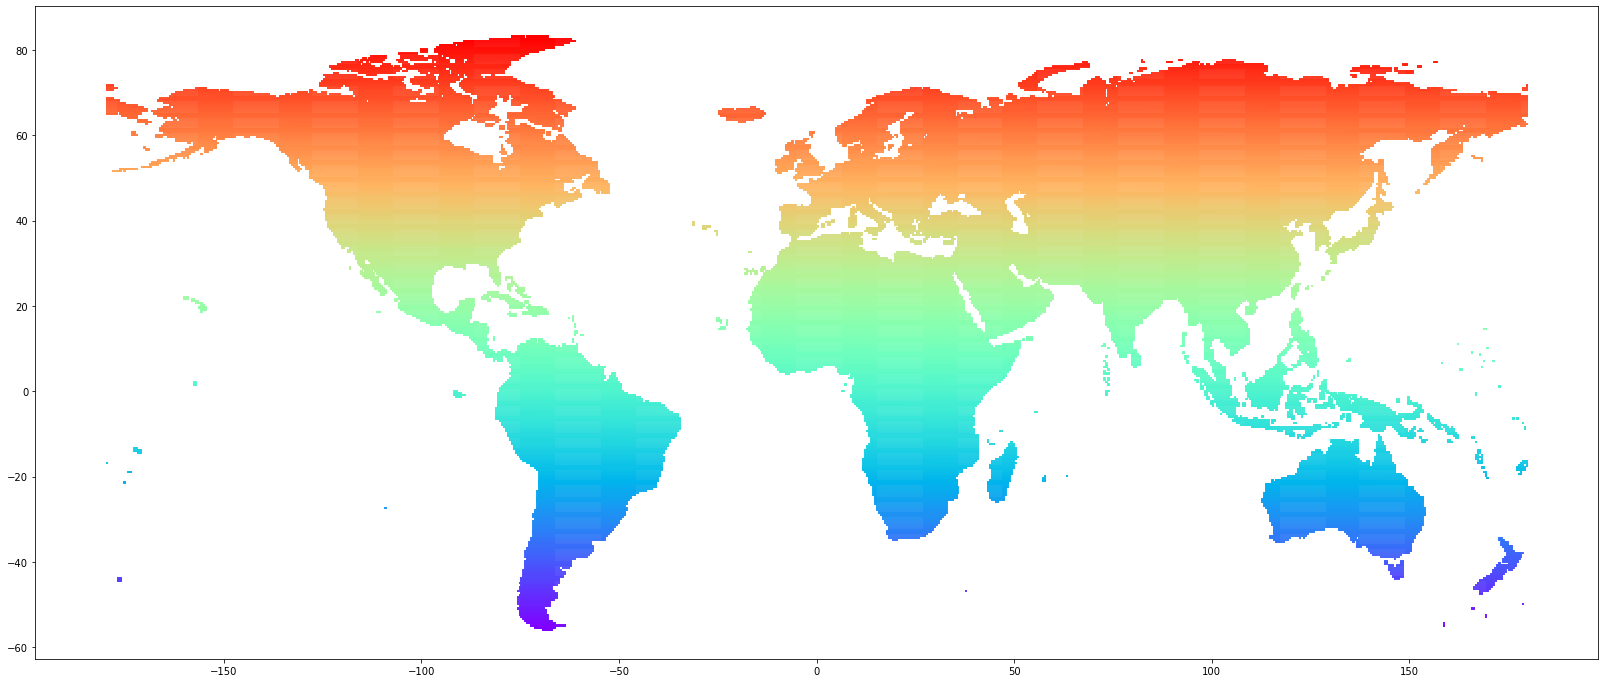

year


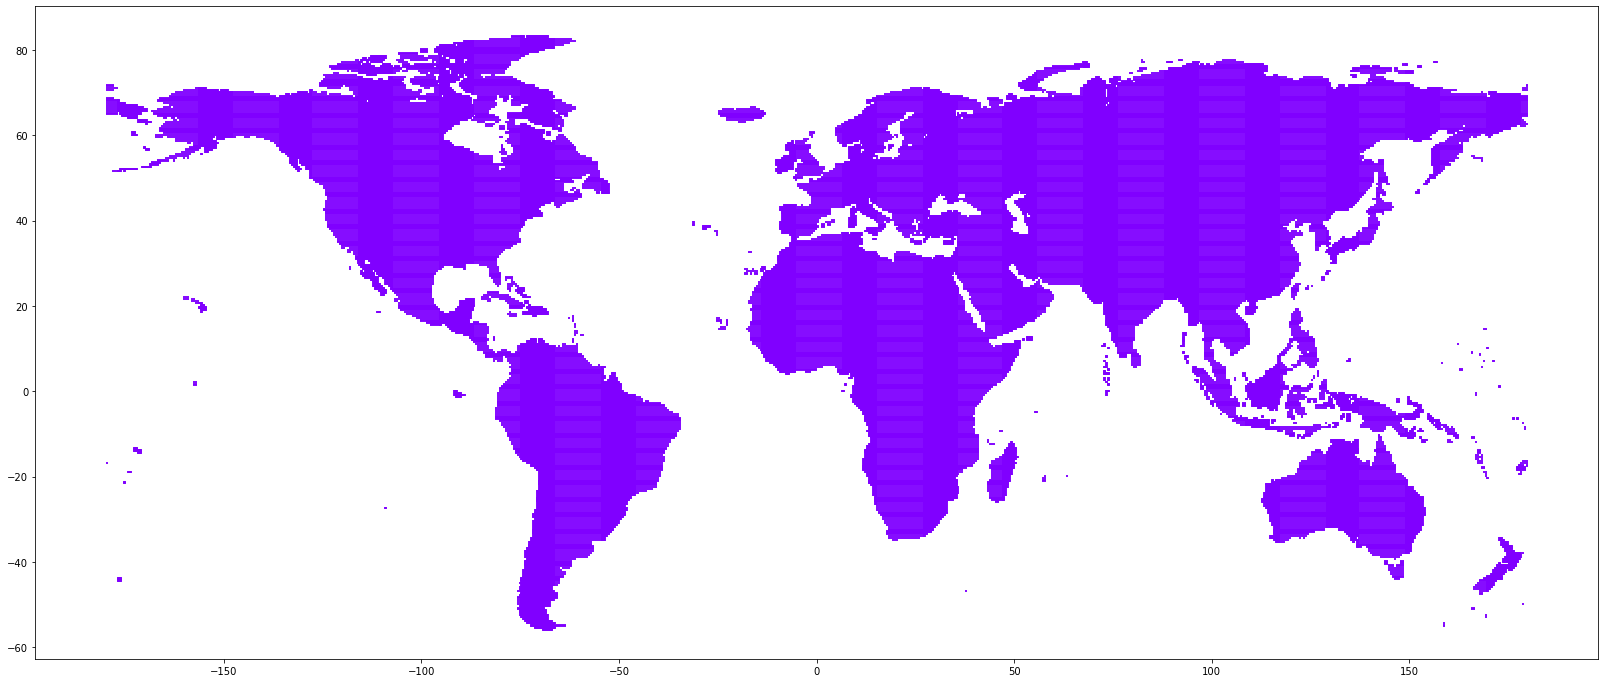

agri_ih


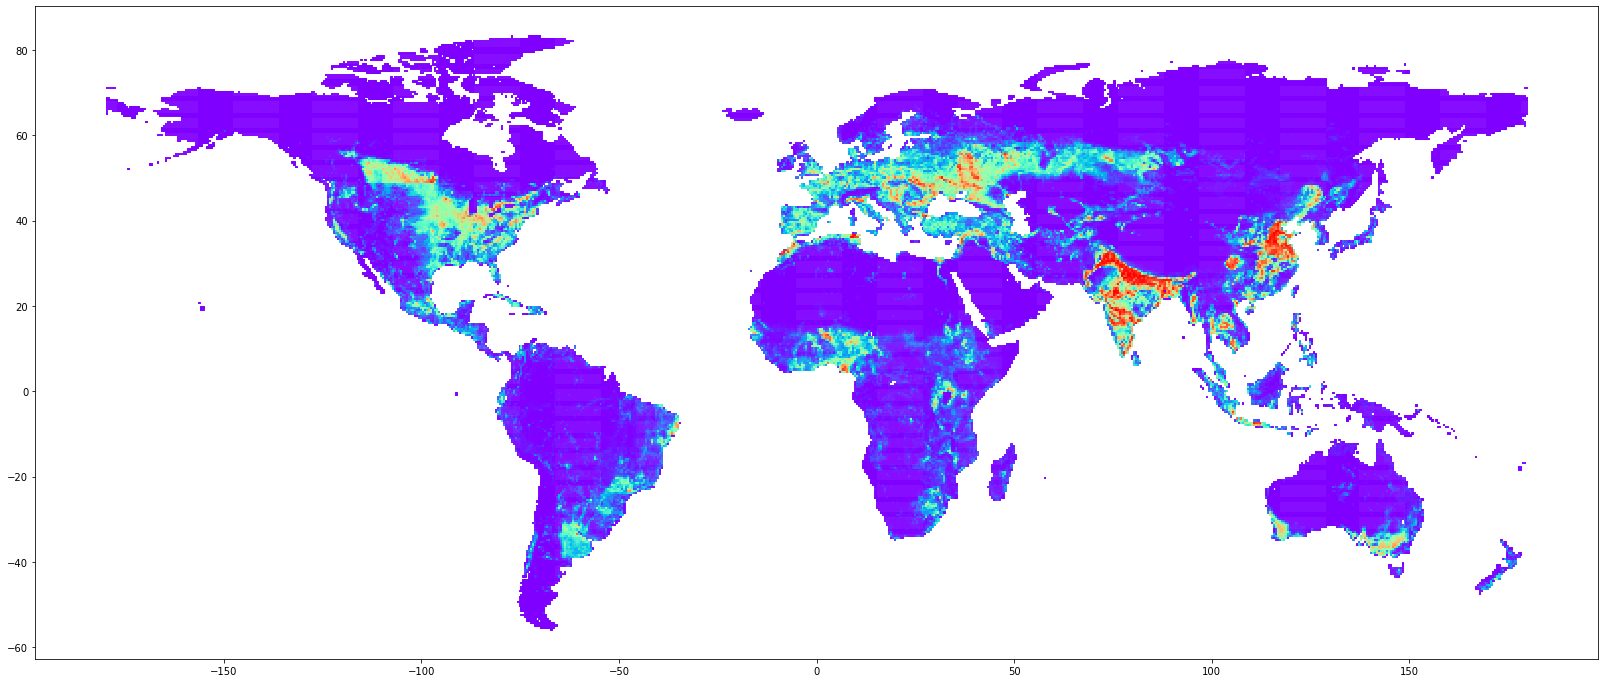

barren_ih


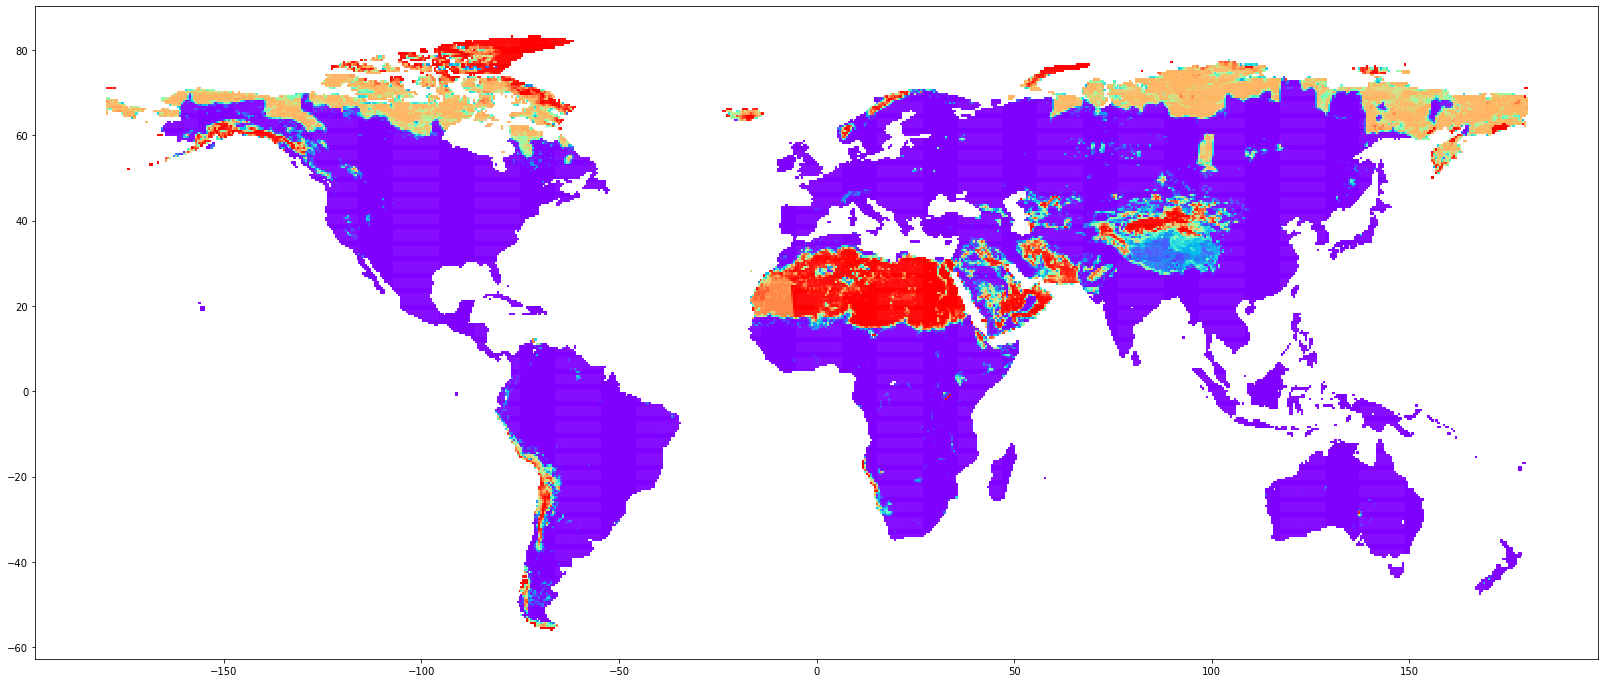

bdist3


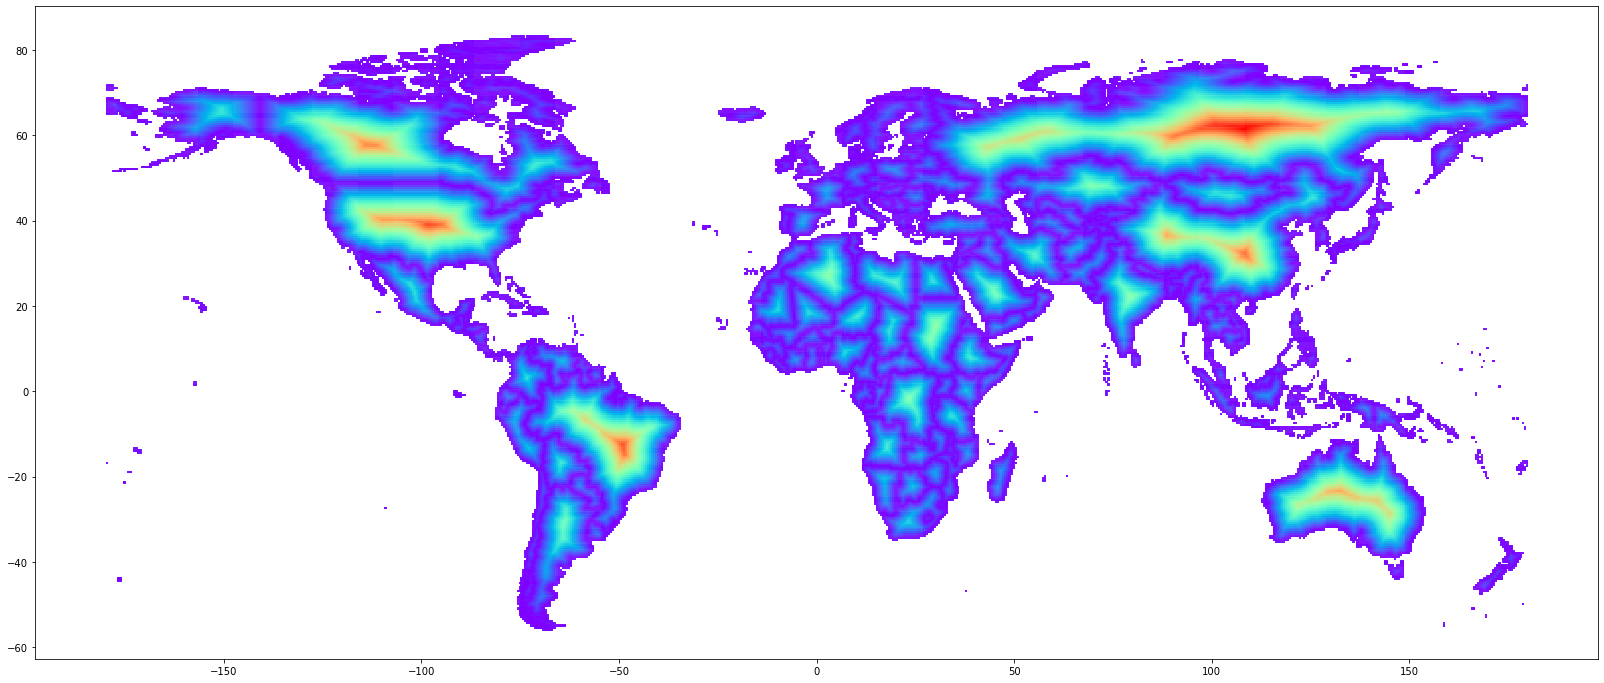

capdist


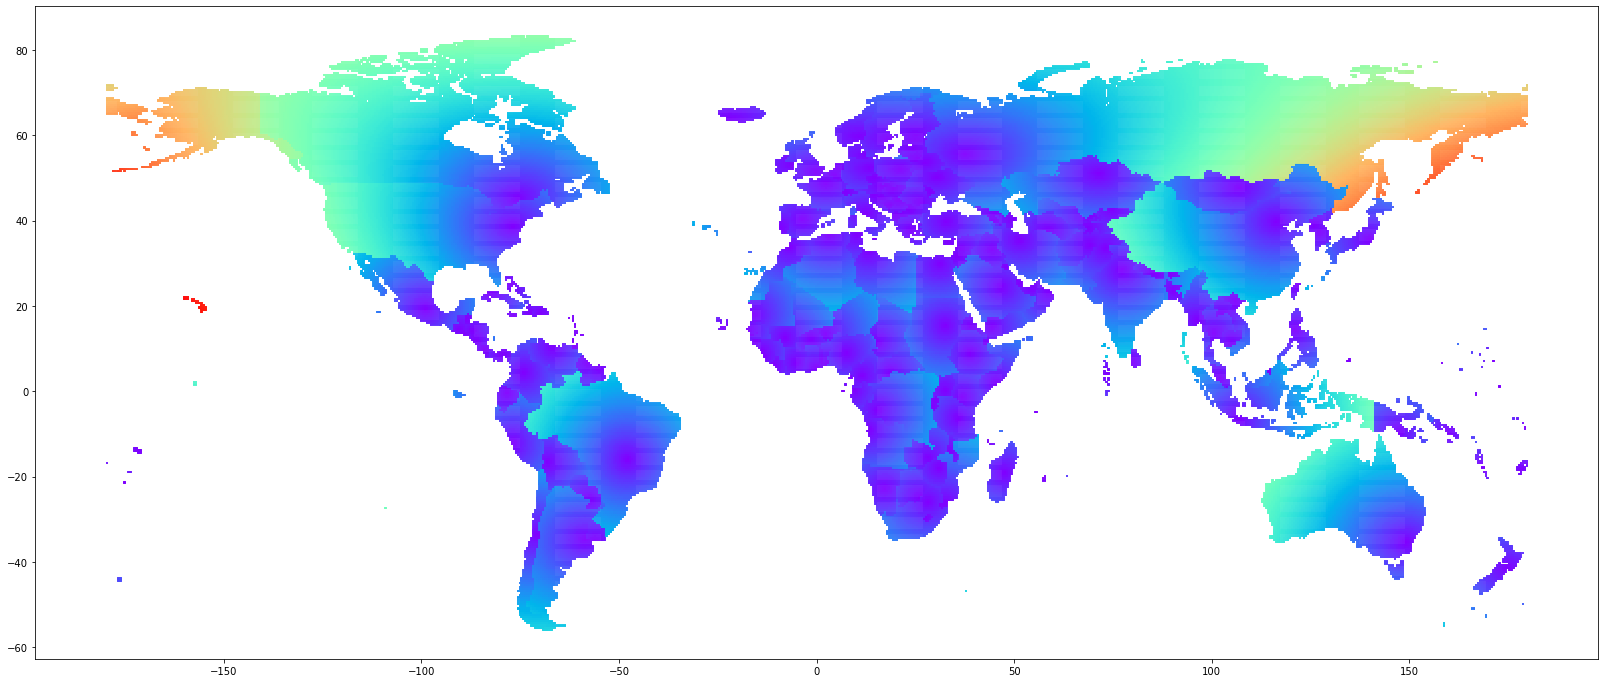

excluded


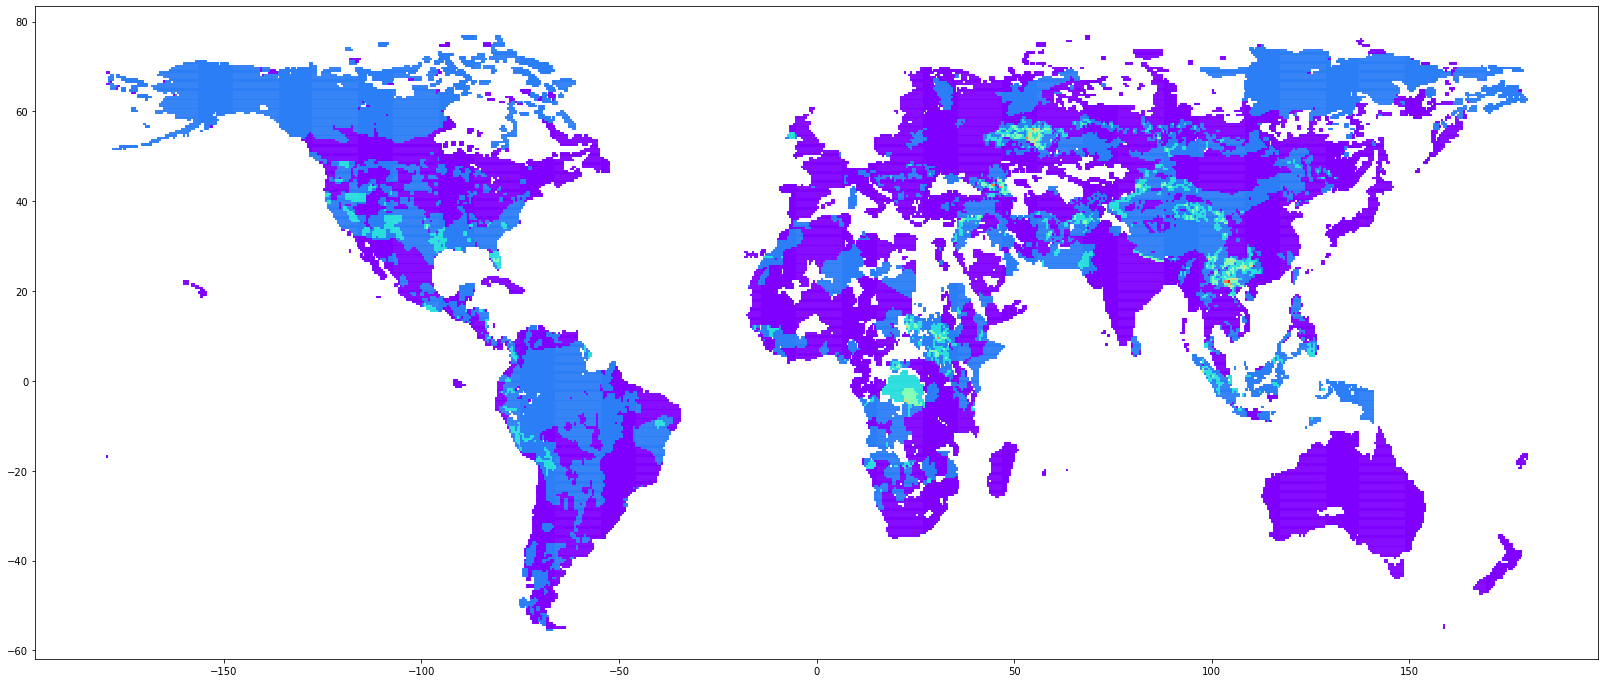

gcp_mer


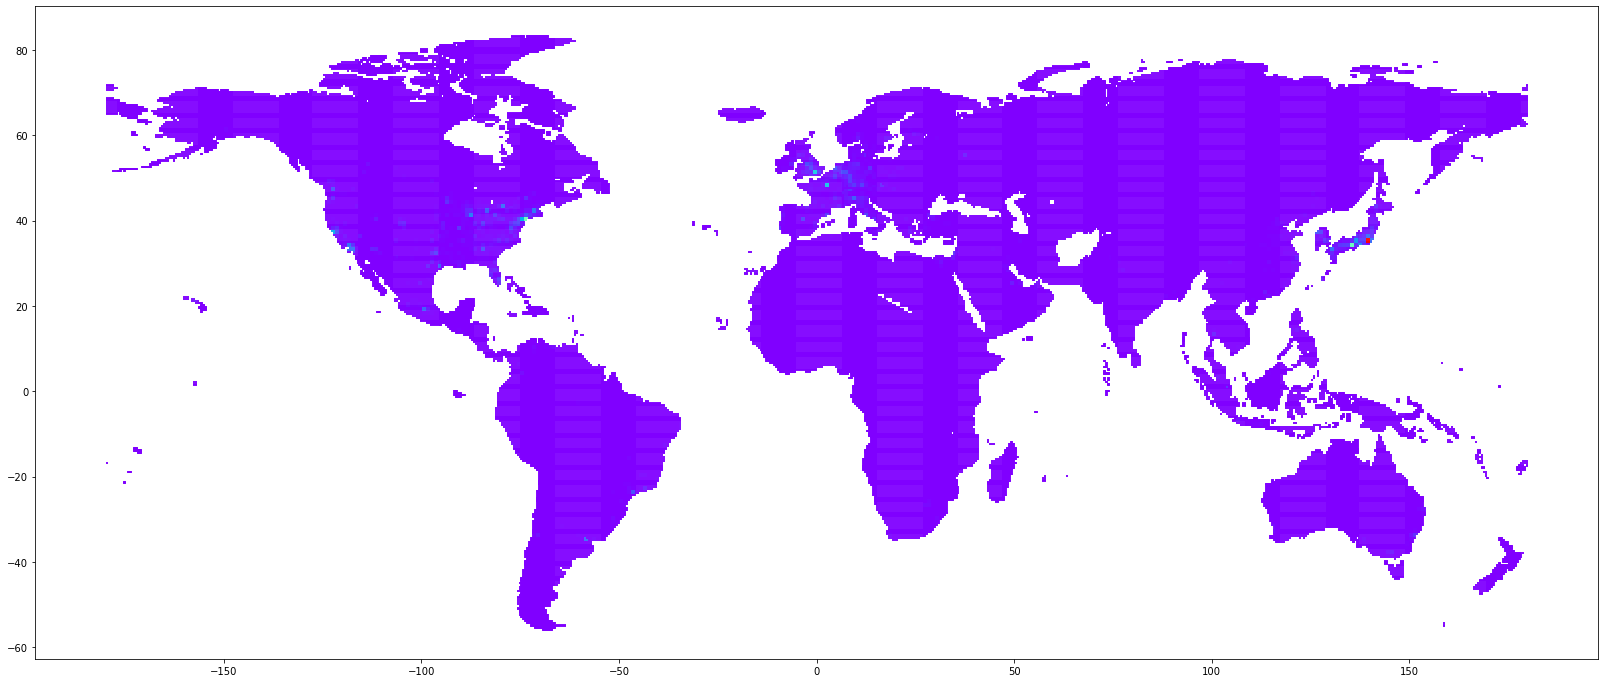

gcp_ppp


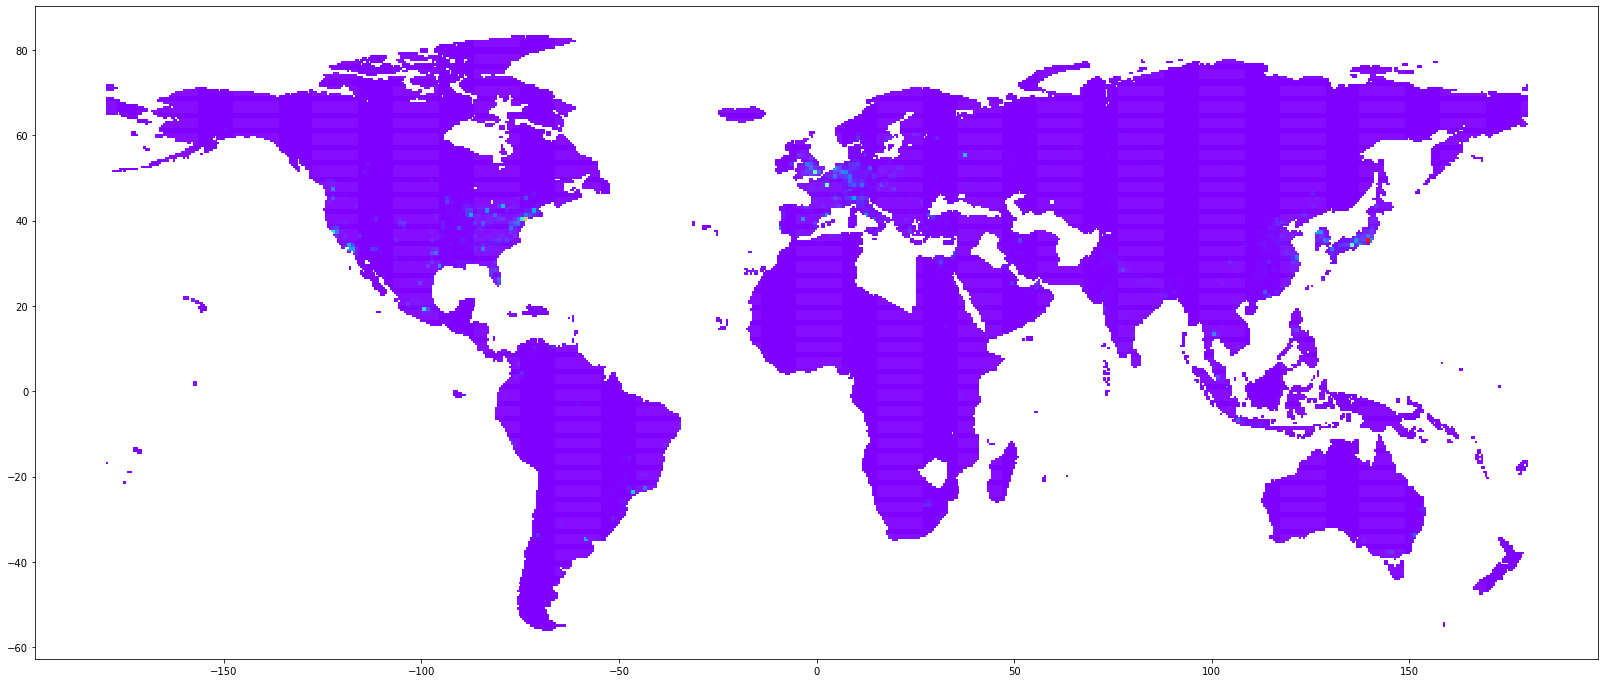

irrig_sum


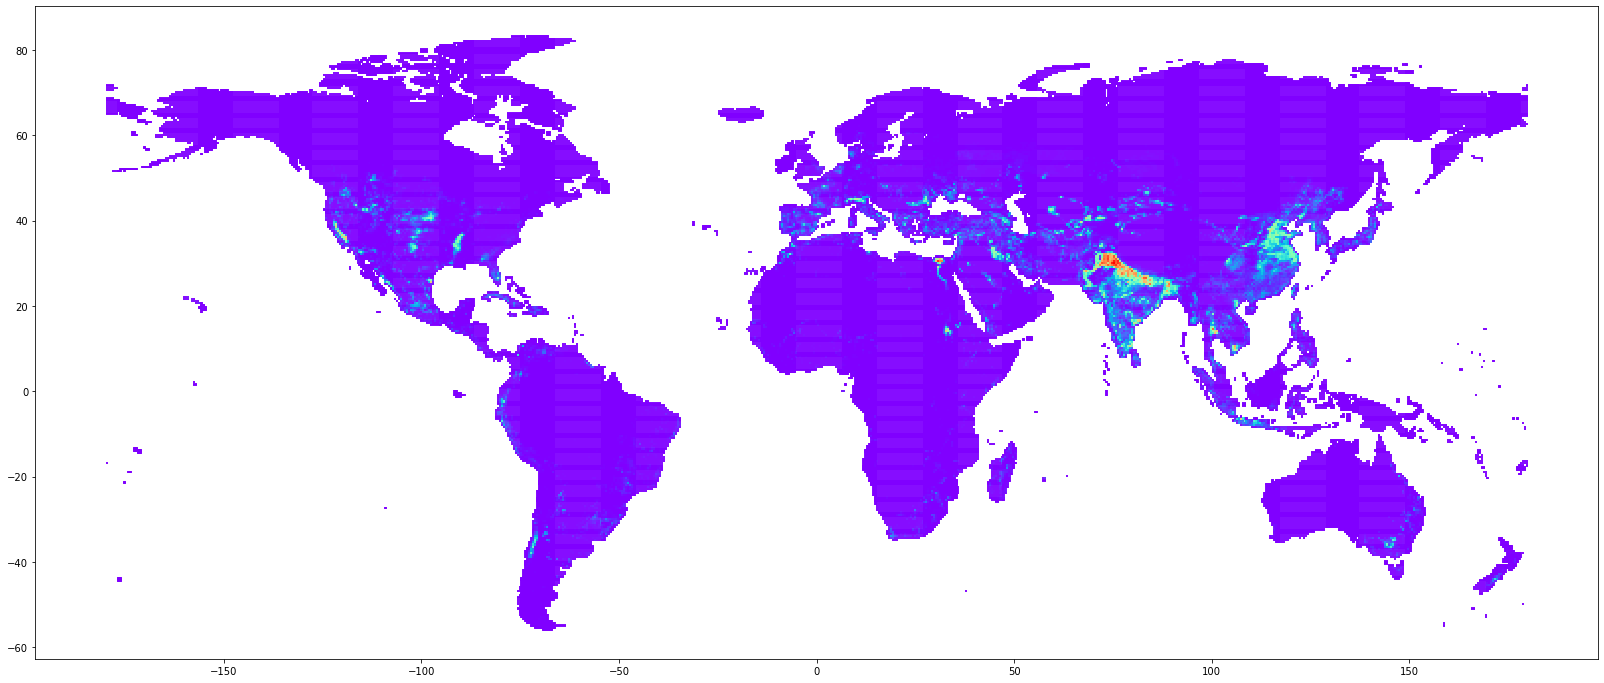

nlights_calib_mean


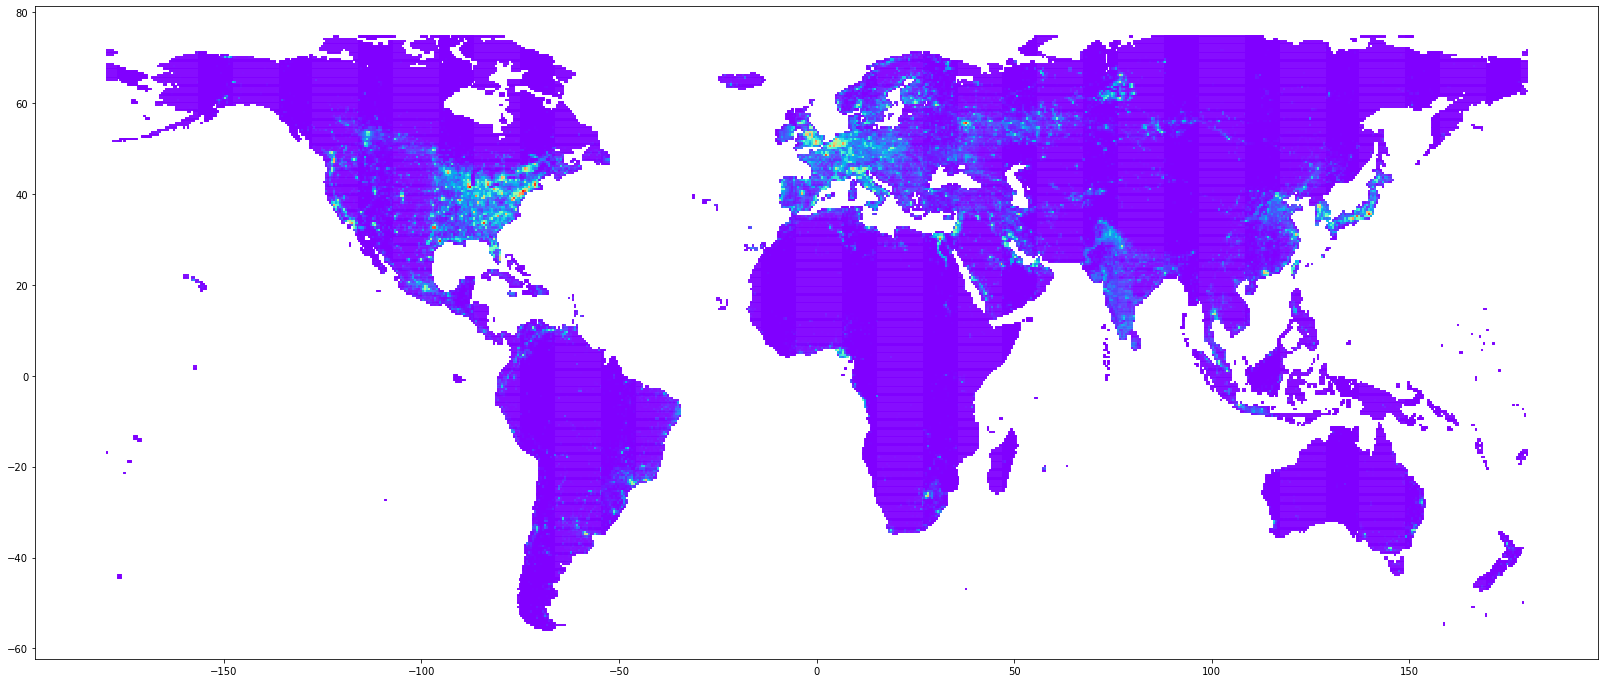

nlights_mean


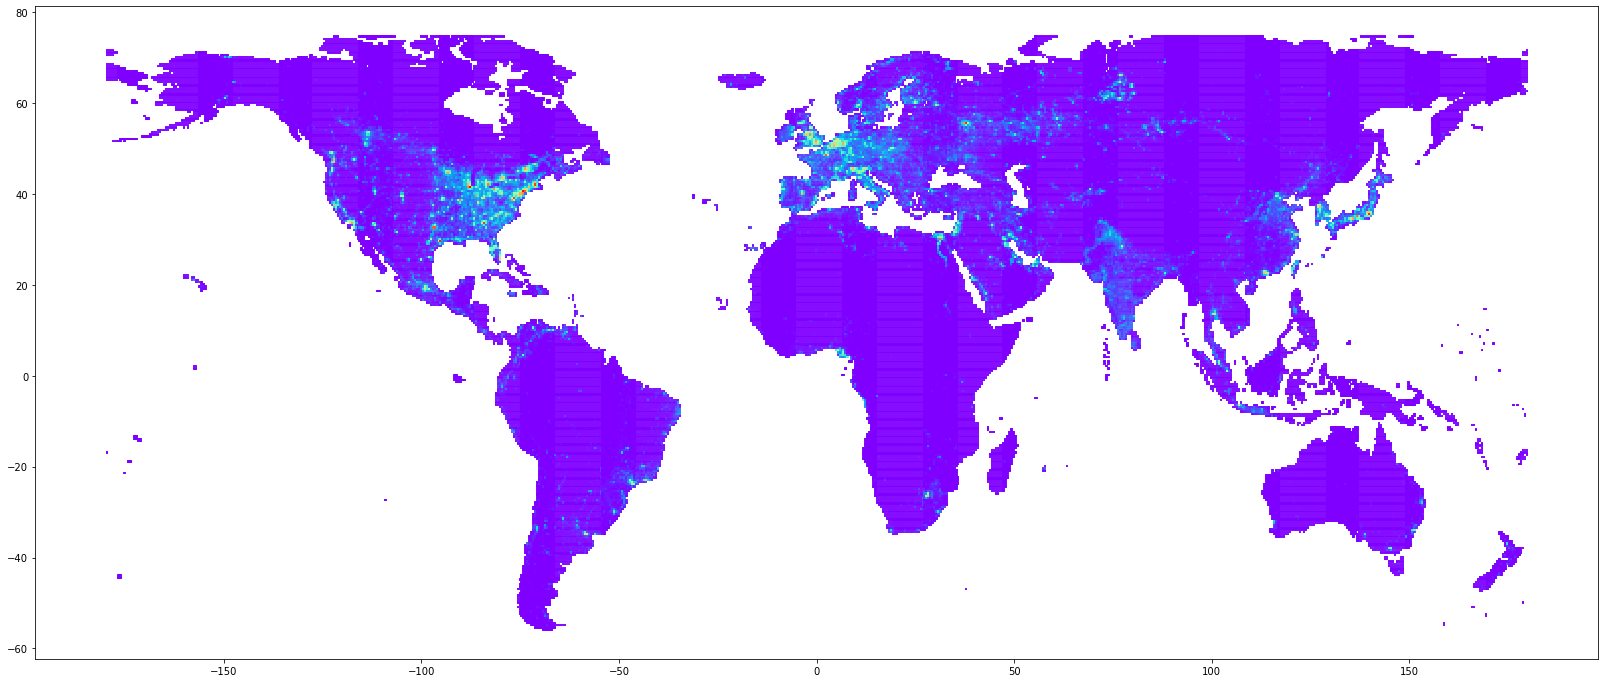

pasture_ih


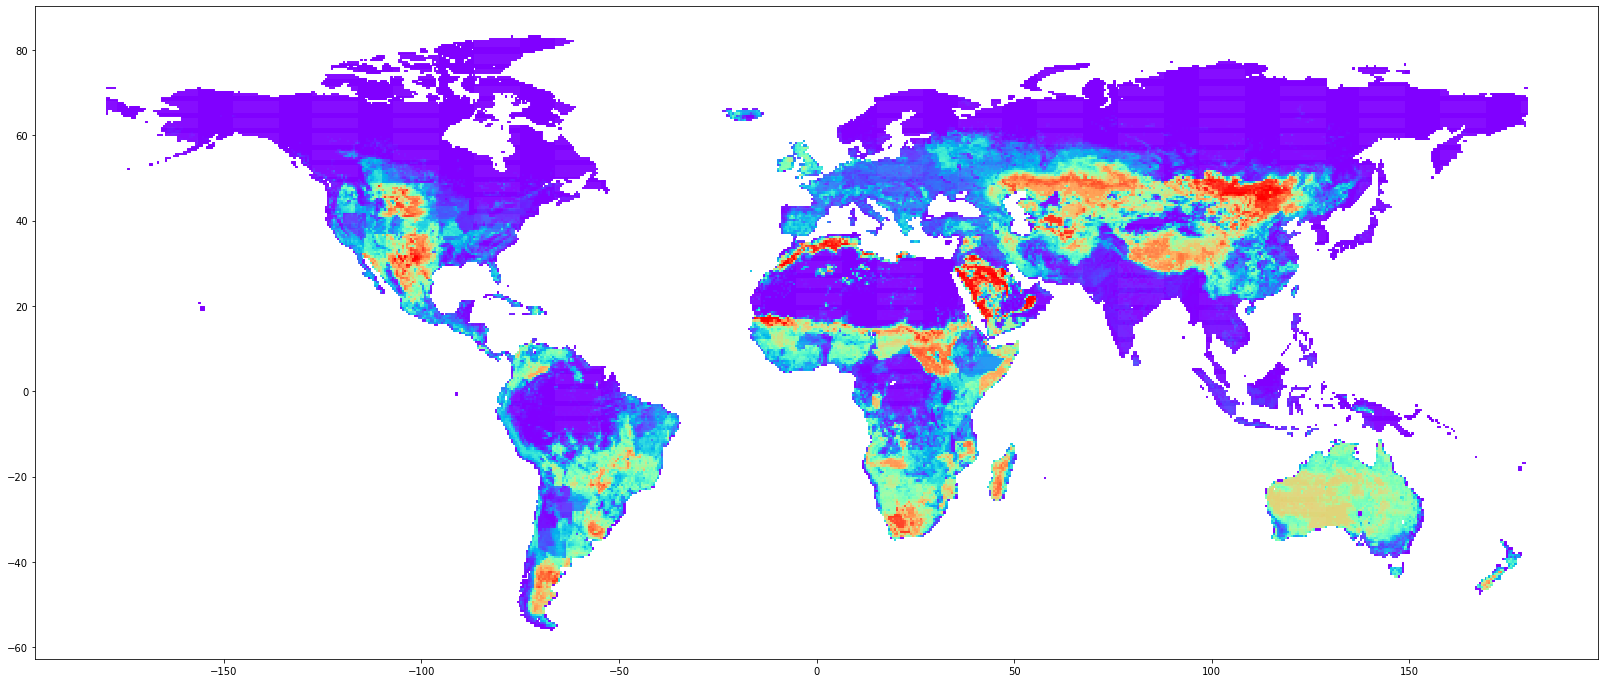

petroleum_y


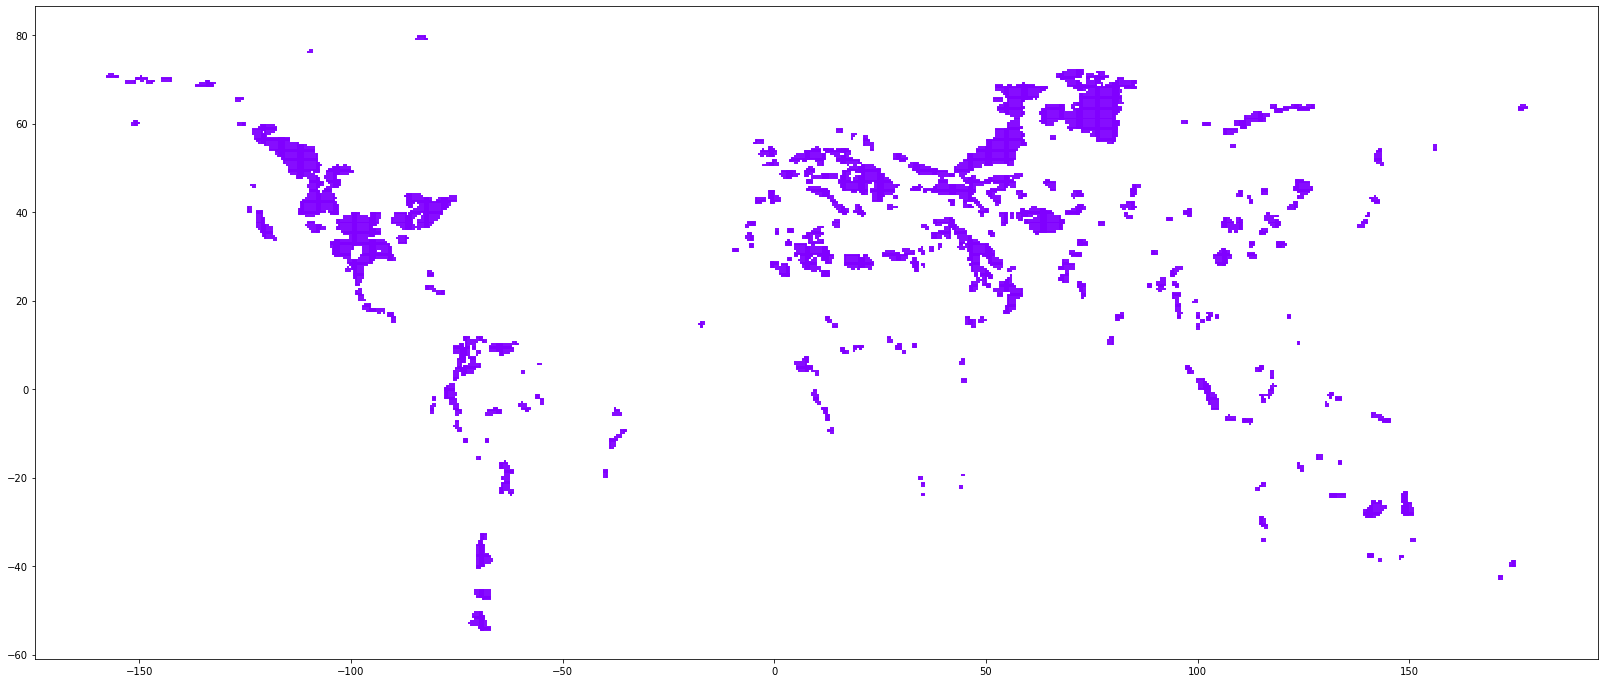

pop_gpw_sd


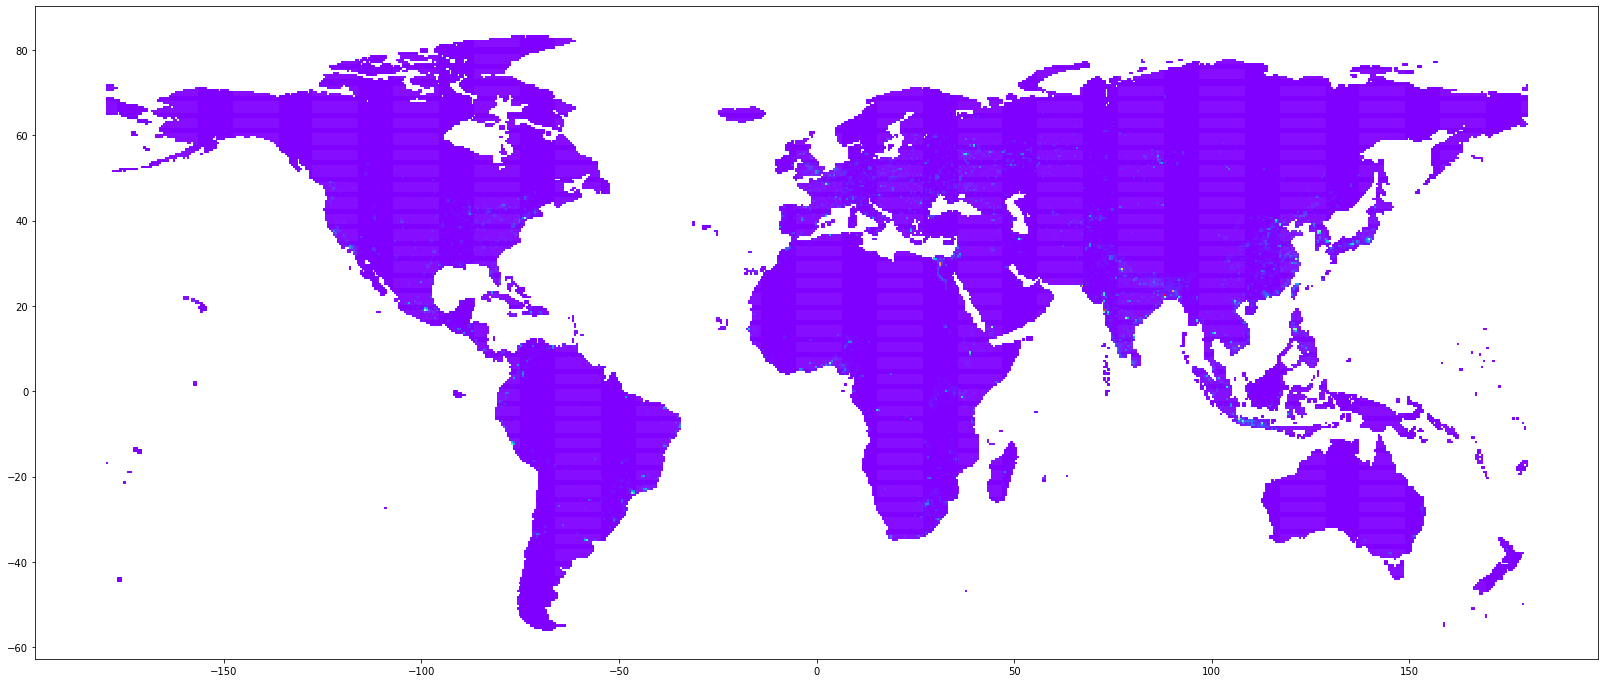

pop_gpw_sum


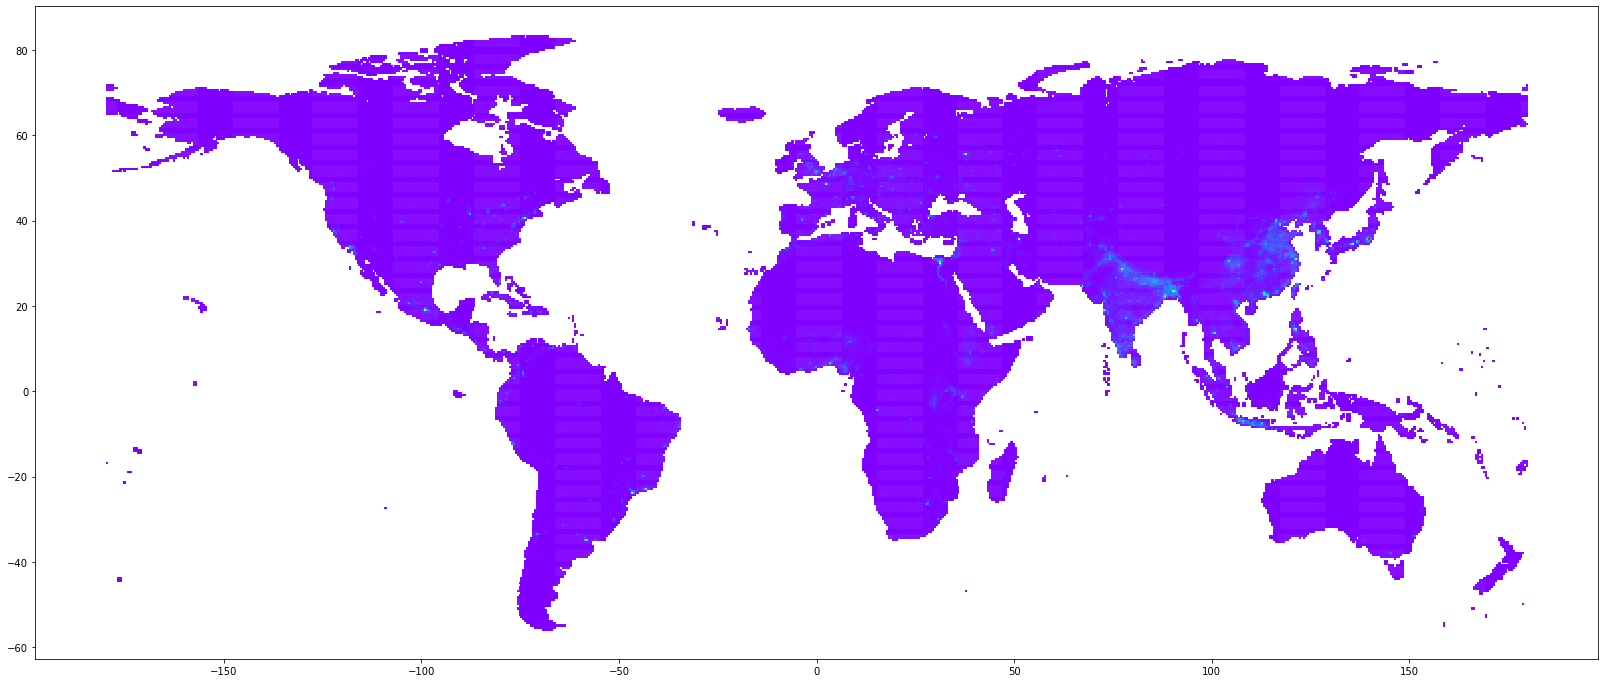

prec_gpcp


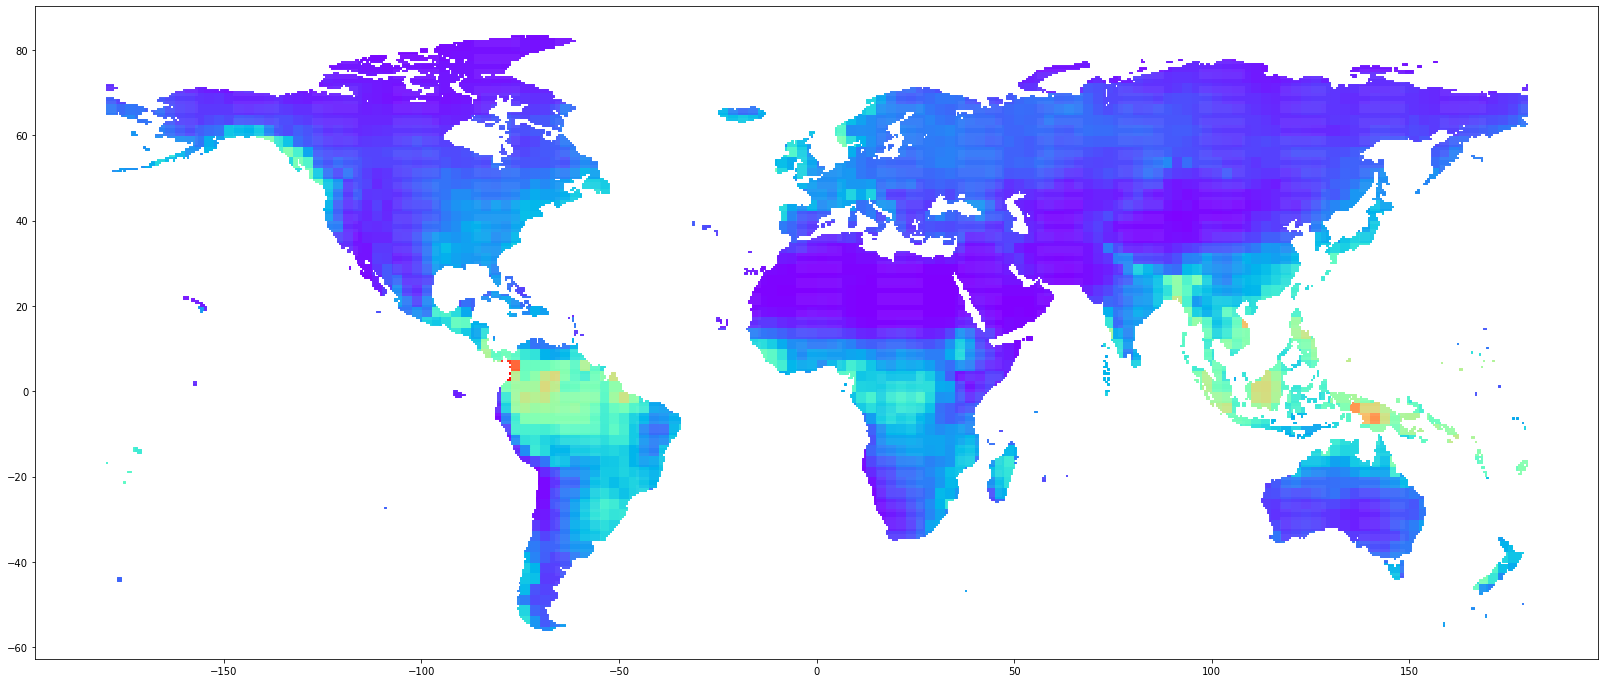

urban_ih


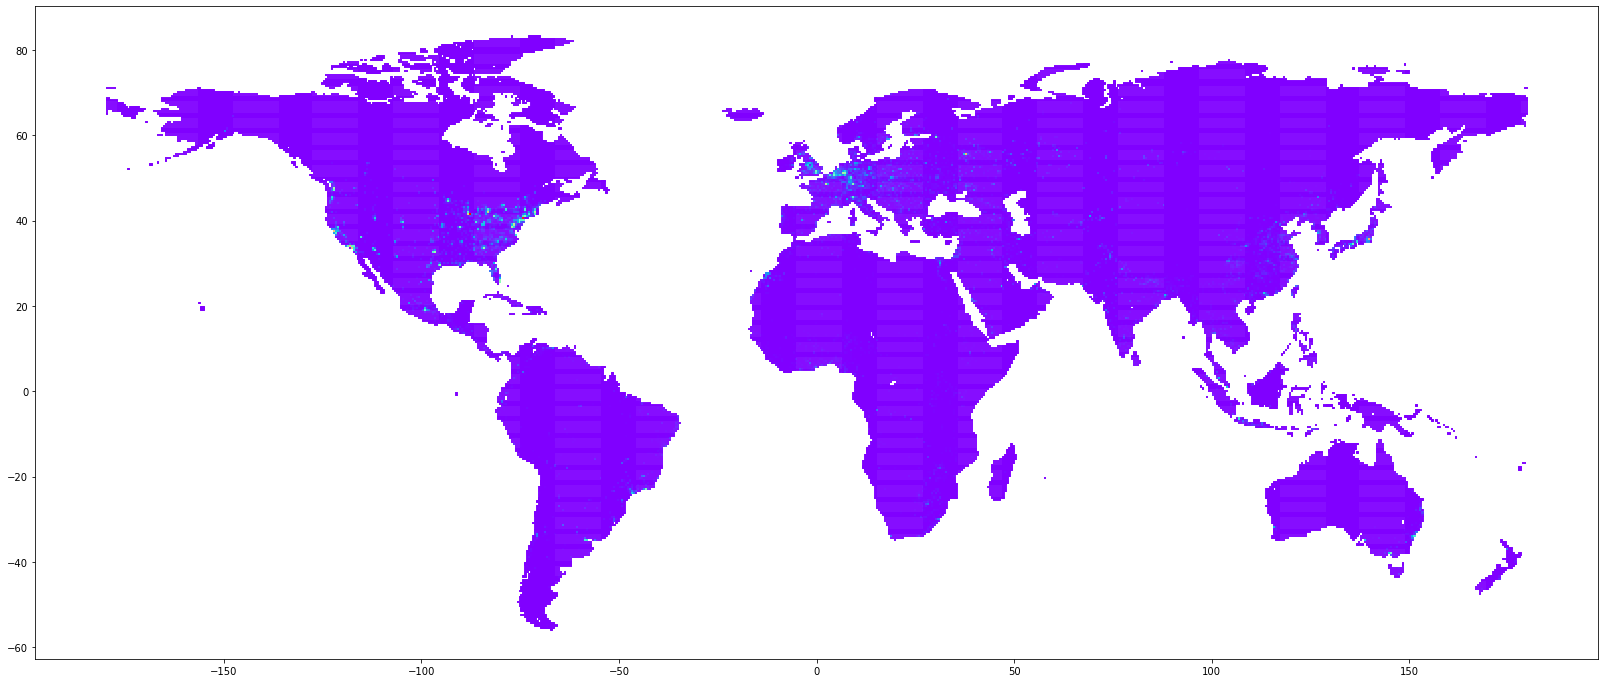

xcoord


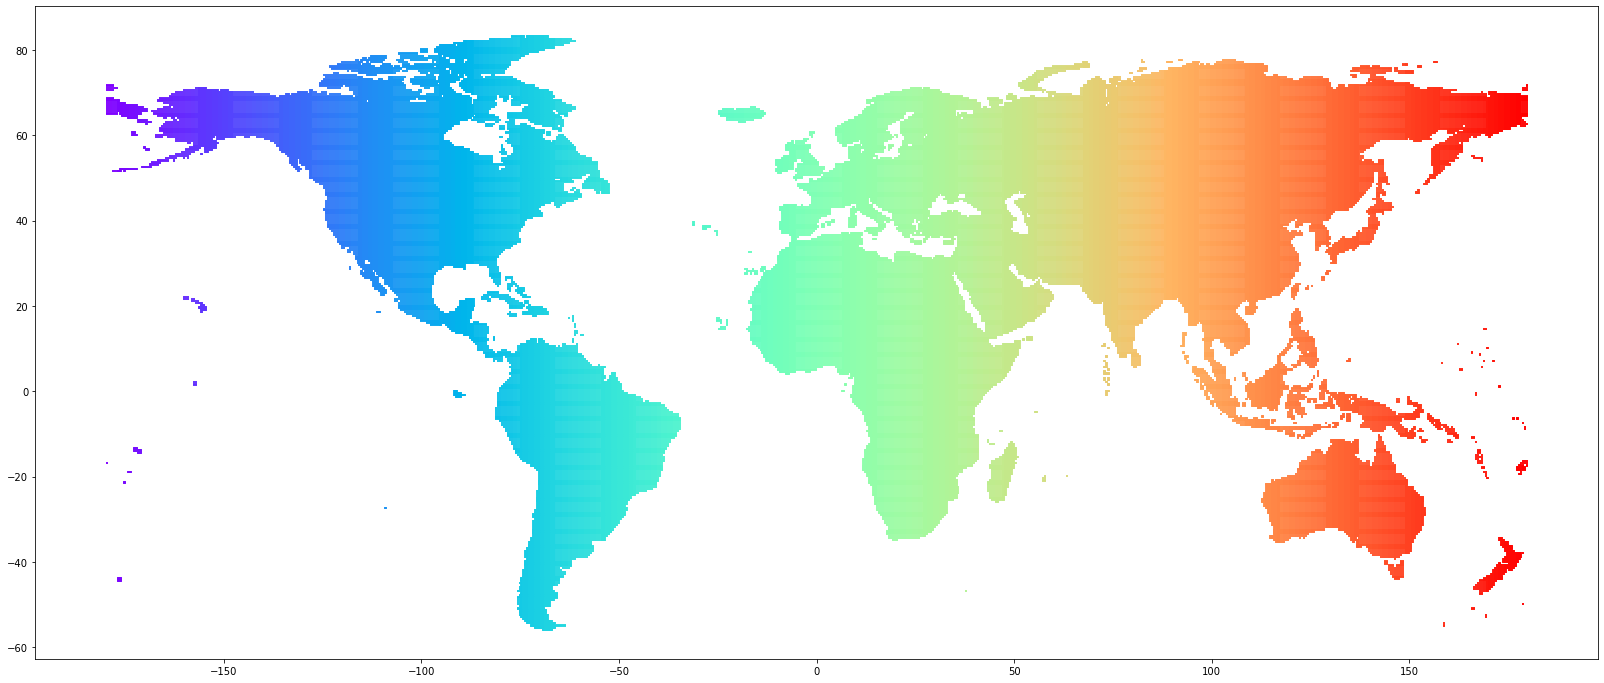

ycoord


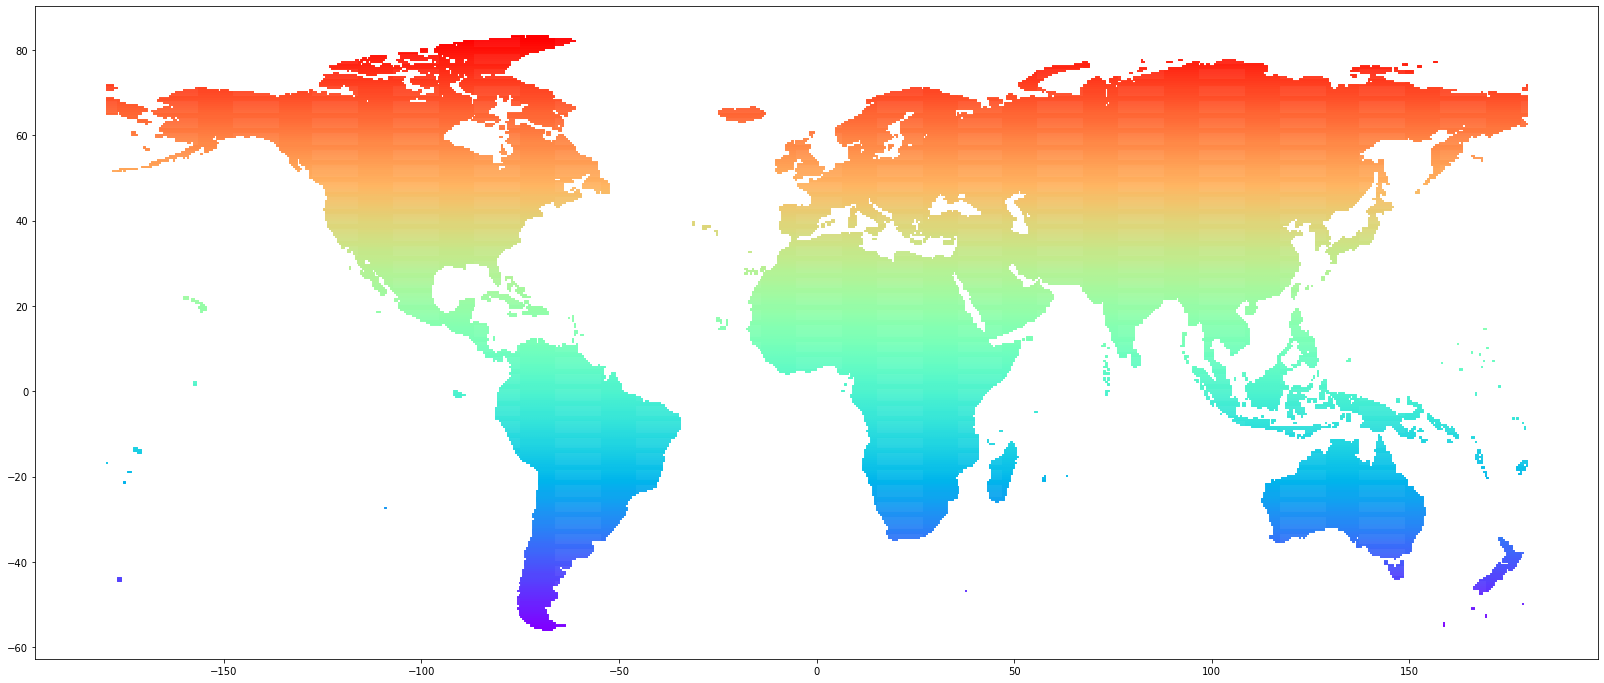

In [ ]:
sub_yearly_df = yearly_df[yearly_df['year'] == 2000]

for col in sub_yearly_df.columns:
    print(col)
    plt.figure(figsize=[28,12])
    plt.scatter(sub_yearly_df['xcoord'], sub_yearly_df['ycoord'], c = sub_yearly_df[col], cmap = 'rainbow', marker = 's', s = 2)
    plt.show()

In [ ]:
#plt.figure(figsize = [14,8])
fig, ax = plt.subplots(figsize = (20,12))
ax.set_aspect('equal')

plt.scatter(sub_prio_ucdp['xcoord'], sub_prio_ucdp['ycoord'], c = np.log(sub_prio_ucdp['best']+1), cmap = 'rainbow', marker = 's', s = 560)
plt.scatter(bodies['longitude_full'].unique()[:-1], bodies['latitude_full'].unique()[:-1], color = 'black', marker = 'x', s = 235)
sub_world.plot(facecolor='none', edgecolor='black', ax=ax)


plt.show()

In [ ]:
yearly_df[yearly_df['year'] == 2000].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64818 entries, 6 to 1685262
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gid                 64818 non-null  int64  
 1   year                64818 non-null  int64  
 2   agri_ih             59951 non-null  float64
 3   barren_ih           59951 non-null  float64
 4   bdist3              64818 non-null  float64
 5   capdist             64818 non-null  float64
 6   excluded            51921 non-null  float64
 7   gcp_mer             63774 non-null  float64
 8   gcp_ppp             62838 non-null  float64
 9   irrig_sum           64685 non-null  float64
 10  nlights_calib_mean  63415 non-null  float64
 11  nlights_mean        63415 non-null  float64
 12  pasture_ih          59951 non-null  float64
 13  petroleum_y         7621 non-null   float64
 14  pop_gpw_sd          64818 non-null  float64
 15  pop_gpw_sum         64818 non-null  float64
 16  pr

In [ ]:
static_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64818 entries, 0 to 64817
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gid             64818 non-null  int64  
 1   row             64818 non-null  int64  
 2   col             64818 non-null  int64  
 3   xcoord          64818 non-null  float64
 4   ycoord          64818 non-null  float64
 5   cmr_mean        44159 non-null  float64
 6   imr_mean        62520 non-null  float64
 7   mountains_mean  61983 non-null  float64
 8   ttime_mean      64717 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 4.5 MB


In [ ]:
def get_gwno():

    location = '/home/simon/Documents/Bodies/data/PRIO'
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download Simply contains the GW contry code and the meta.

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno




 # Why some features that might be interesting are not here:

Fra Uppsala:

- event_clarity 
- date_prec 
- type_of_violence

Fra Prio


In [ ]:
data_dir = '/home/simon/Documents/Bodies/data/OD_dataframes_compiled/'

with open(f'{data_dir}bodies_df_exposure.pkl', 'rb') as file:
    df = pickle.load(file)

In [ ]:
df

,person_mean,person_median,person_fasterR50,person_fasterR101,person_fasterX101,person_retinaR50,person_retinaR101,child_mean,child_median,child_retinaR50,...,year_month,month_id,new_year,index_right,gid,log_best,log_high,log_low,tce,tsce
0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,2008-12,348.0,2008,400824.0,177569.0,1.791759,1.791759,1.791759,2.082460,1.076649
1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,2009-09,357.0,2009,400824.0,177569.0,1.791759,1.791759,1.791759,3.019779,1.429009
2,1.6,2.0,2.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,...,2007-10,334.0,2007,400824.0,177569.0,3.367296,4.174387,3.367296,3.337597,1.954353
3,2.8,3.0,2.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,...,2005-11,311.0,2005,341604.0,179003.0,4.941642,5.056246,4.941642,2.927739,1.476241
4,1.8,2.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,2005-11,311.0,2005,341604.0,179003.0,4.941642,5.056246,4.941642,2.927739,1.476241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152427,0.6,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,2004-01,289.0,2004,341424.0,179009.0,0.000000,0.000000,0.000000,-0.024481,-0.015471
152428,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,...,2004-01,289.0,2004,341424.0,179009.0,0.000000,0.000000,0.000000,-0.024481,-0.015471
152429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2004-01,289.0,2004,341424.0,179009.0,0.000000,0.000000,0.000000,-0.024481,-0.015471
152430,4.8,5.0,5.0,5.0,5.0,5.0,4.0,1.5,1.5,2.0,...,2004-01,289.0,2004,341424.0,179009.0,0.000000,0.000000,0.000000,-0.024481,-0.015471
